In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loaded dataset with 170 samples and 5 classes.


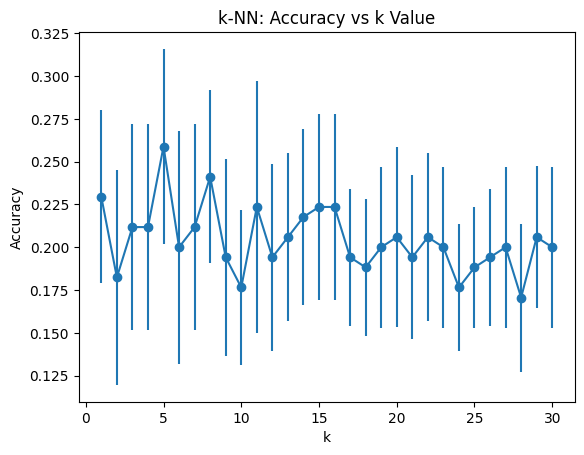

Best k: 5
Final accuracy with k=5: 0.2235294117647059


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from PIL import Image
import os

def preprocess_image(image, size=(32, 32)):
    image_resized = Image.fromarray(image).resize(size).convert('L')
    return np.array(image_resized)

def load_dataset(dataset_dir):
    data = []
    labels = []
    classes = sorted(os.listdir(dataset_dir))
    class_map = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            try:
                img = np.array(Image.open(img_path))
                img_gray = preprocess_image(img)
                data.append(img_gray.flatten())
                labels.append(class_map[cls])
            except Exception as e:
                print(f"Could not process image {img_name}: {e}")

    return np.array(data), np.array(labels), class_map

class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k)

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.sqrt(
            np.sum(X ** 2, axis=1, keepdims=True) +
            np.sum(self.X_train ** 2, axis=1) -
            2 * X @ self.X_train.T
        )
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            nearest = np.argsort(dists[i])[:k]
            closest_y = self.y_train[nearest]
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

dataset_dir = '/content/drive/MyDrive/Animals'
X, y, class_map = load_dataset(dataset_dir)
print(f"Loaded dataset with {len(X)} samples and {len(class_map)} classes.")

num_folds = 5
k_choices = range(1, 31)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

k_to_accuracies = {k: [] for k in k_choices}

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    knn = KNearestNeighbor()
    knn.train(X_train, y_train)

    for k in k_choices:
        y_val_pred = knn.predict(X_val, k=k)
        accuracy = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(accuracy)

mean_accuracies = []
std_accuracies = []

for k in k_choices:
    accuracies = k_to_accuracies[k]
    mean_accuracies.append(np.mean(accuracies))
    std_accuracies.append(np.std(accuracies))

plt.errorbar(k_choices, mean_accuracies, yerr=std_accuracies, fmt='-o')
plt.title("k-NN: Accuracy vs k Value")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

best_k = k_choices[np.argmax(mean_accuracies)]
print(f"Best k: {best_k}")

knn = KNearestNeighbor()
knn.train(X, y)
y_pred = knn.predict(X, k=best_k)
accuracy = np.mean(y_pred == y)
print(f"Final accuracy with k={best_k}: {accuracy}")
